<a href="https://colab.research.google.com/github/Cheer3142/OMPnIHT_implement/blob/main/OMPandN_IHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
def omp(y, Theta, K):
    """
    Orthogonal Matching Pursuit (OMP)

    Args:
        Theta: Measurement matrix (m x N)
        y: Measurements vector (m,)
        K: Sparsity level

    Returns:
        s_hat: Sparse solution (N,)
    """
    m, N = Theta.shape
    residual = y.copy()
    Gamma = []
    s_hat = np.zeros(N)

    for _ in range(K):
        # Step 3: Find best fitting column
        correlations = Theta.T @ residual
        lambda_i = np.argmax(np.abs(correlations))

        # Step 4: Append Best fit column
        Gamma.append(lambda_i)
        # print("lambda i:", lambda_i)

        # Step 5: LS optimization
        Theta_Gamma = Theta[:, Gamma]
        s_Gamma, _, _, _ = np.linalg.lstsq(Theta_Gamma, y, rcond=None)

        # Step 6: Residual update
        residual = y - Theta_Gamma @ s_Gamma
        if np.mean((y - Theta_Gamma @ s_Gamma) ** 2) < 0.2:
          break

    s_hat[Gamma] = s_Gamma
    # print(s_hat.shape)
    return s_hat

In [ ]:
def n_iht(y, A, k, iteration, w = 0.01):
    _, N = A.shape
    xnew = np.zeros(N)
    r = y # - A @ xnew

    for i in range(iteration):
        g = A.T @ r

        x = xnew + w * g

        # Hard thresholding: keep top-k absolute values
        s = np.argsort(np.abs(x))[::-1]
        T = s[:k]

        xnew[:] = 0
        xnew[T] = x[T]

        r = y - A @ xnew

    return xnew

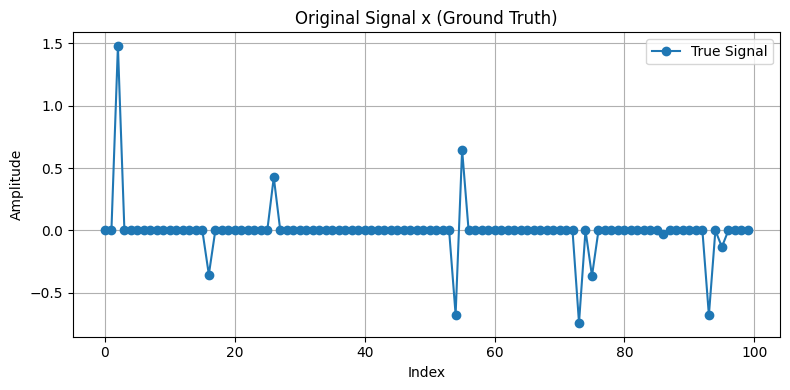

In [ ]:
# --- Example setup ---
np.random.seed(0)
N = 100        # Signal length
M = 40         # Number of measurements
k = 10         # Sparsity level
iterations = 100

# Random k-sparse signal
x_true = np.zeros(N)
nonzero_indices = np.random.choice(N, k, replace=False)
x_true[nonzero_indices] = np.random.randn(k)

# Measurement matrix and observed signal
A = np.random.randn(M, N)
y = A @ x_true

# --- Plotting ---
plt.figure(figsize=(8, 4))
plt.plot(x_true, label='True Signal', marker='o')
plt.title('Original Signal x (Ground Truth)')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
%%timeit
x_omp = omp(y, A, k)

2.82 ms ± 719 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
x_iht = n_iht(y, A, k, iterations)

1.68 ms ± 358 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


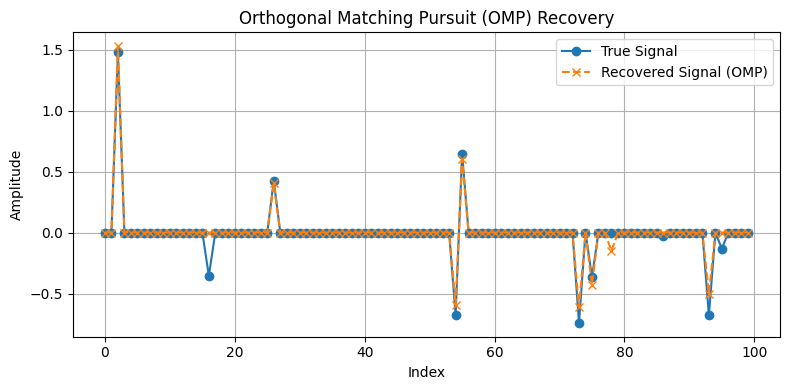

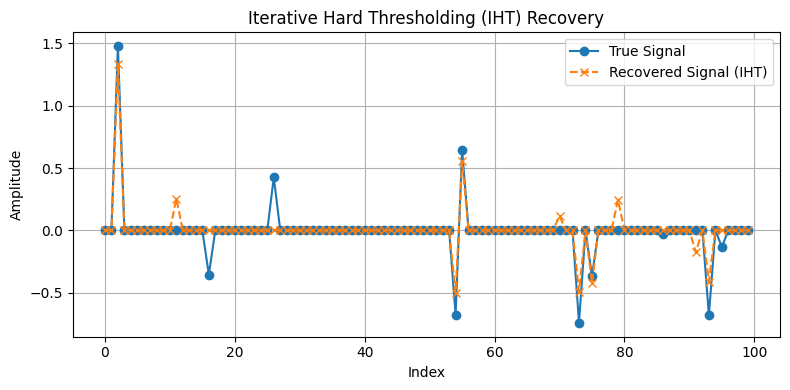


OMP Mean Squared Error (MSE): 0.002310
IHT Mean Squared Error (MSE): 0.006909


In [ ]:
# Recovery
# x_amp = amp(y, A)
x_omp = omp(y, A, k)
x_iht = n_iht(y, A, k, iterations)

# --- Plotting ---
plt.figure(figsize=(8, 4))
plt.plot(x_true, label='True Signal', marker='o')
plt.plot(x_omp, label='Recovered Signal (OMP)', linestyle='--', marker='x')
plt.title('Orthogonal Matching Pursuit (OMP) Recovery')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print('\n')

plt.figure(figsize=(8, 4))
plt.plot(x_true, label='True Signal', marker='o')
plt.plot(x_iht, label='Recovered Signal (IHT)', linestyle='--', marker='x')
plt.title('Iterative Hard Thresholding (IHT) Recovery')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse = np.mean((x_true - x_omp) ** 2)
print(f"\nOMP Mean Squared Error (MSE): {mse:.6f}")

# --- Error Metrics ---
mse = np.mean((x_true - x_iht) ** 2)
print(f"IHT Mean Squared Error (MSE): {mse:.6f}")


In [ ]:
# Support recovery: indices where x_true is non-zero
support_true = set(np.nonzero(x_true)[0])
support_est = set(np.nonzero(x_iht)[0])
support_intersection = support_true.intersection(support_est)
support_accuracy = len(support_intersection) / len(support_true)

print(f"Support Recovery Accuracy: {support_accuracy * 100:.2f}%")

support_true = set(np.nonzero(x_true)[0])
support_est = set(np.nonzero(x_omp)[0])
support_intersection = support_true.intersection(support_est)
support_accuracy = len(support_intersection) / len(support_true)

print(f"Support Recovery Accuracy: {support_accuracy * 100:.2f}%")


Support Recovery Accuracy: 60.00%
Support Recovery Accuracy: 70.00%


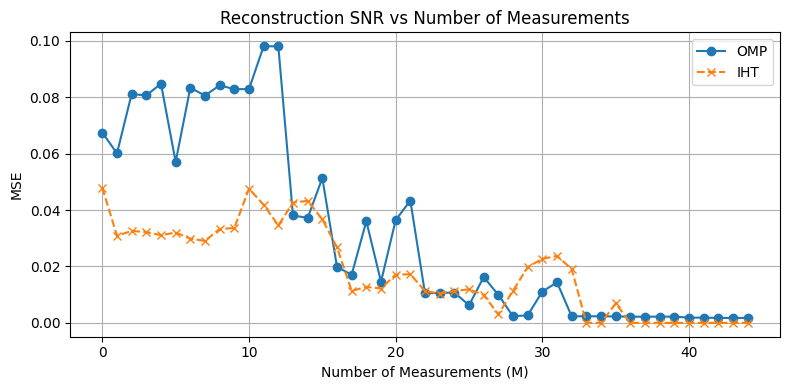

In [ ]:
lst_mse_omp =[]
lst_mse_iht =[]

def calculate_snr(original, reconstructed):
    """Calculate Signal-to-Noise Ratio (SNR) in dB"""
    signal_power = np.sum(original**2)
    noise_power = np.sum((original - reconstructed)**2)
    return 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')

for m in range(5, 50, 1):
  # --- Example setup ---
  np.random.seed(0)
  N = 100        # Signal length
  M = m         # Number of measurements
  k = 10         # Sparsity level
  iterations = 100

  # Random k-sparse signal
  x_true = np.zeros(N)
  nonzero_indices = np.random.choice(N, k, replace=False)
  x_true[nonzero_indices] = np.random.randn(k)

  # Measurement matrix and observed signal
  A = np.random.randn(M, N)
  y = A @ x_true

  x_omp = omp(y, A, k)
  x_iht = n_iht(y, A, k, iterations)

  lst_mse_omp.append(np.mean((x_true - x_omp) ** 2))
  # print(f"OMP Mean Squared Error (MSE): {mse:.6f}")

  # --- Error Metrics ---
  lst_mse_iht.append(np.mean((x_true - x_iht) ** 2))
  # print(f"IHT Mean Squared Error (MSE): {mse:.6f}")

plt.figure(figsize=(8, 4))
plt.plot(lst_mse_omp, label='OMP', marker='o')
plt.plot(lst_mse_iht, label='IHT', linestyle='--', marker='x')
plt.title('Reconstruction SNR vs Number of Measurements')
plt.xlabel('Number of Measurements (M)')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()